In [1]:
import dataset3

In [2]:
data3 = dataset3.load_data(1)

In [10]:
import rec3
reload (rec3)

<module 'rec3' from 'rec3.py'>

ae

In [4]:
import torch
import torch.nn as nn
import os
import numpy as np

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd



In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.representations = dict()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.encoder(x)
        self.representations['hidden'] = out.data.numpy().copy()
        out = self.relu(out)
        self.representations['hidden_relu'] = out.data.numpy().copy()
        out = self.decoder(out)
        self.representations['decode'] = out.data.numpy().copy()
        out = self.sigmoid(out)
        self.representations['decode_sigmoid'] = out.data.numpy().copy()
        return out

In [9]:
def rec_pred(pred_ratings):
    pred = rec3.Rec()
    pred.set_prediction_matrix(data3.train_dataset.known, pred_ratings)
    pred.produce_rec_list(data3.train_dataset.known,targets=data3.test_dataset.targets)
    pred.evaluate(test= data3.test_dataset.test, rec_len=5)
    return pred

In [11]:
tmp = np.random.random(data3.train_dataset.train.shape)
rec_pred(pred_ratings=tmp).precision_

0.022516556291390731

In [12]:
who

DataLoader	 Dataset	 Net	 Variable	 data3	 dataset3	 nn	 np	 os	 
pd	 plt	 rec3	 rec_pred	 tmp	 torch	 


training example with input

In [16]:
input_size = 6040
hidden_size = 350
output_size = 6040
loss_history = list()
learning_rate = 0.001



num_epochs = 40

cv = 1



Net (
  (encoder): Linear (6040 -> 350)
  (relu): ReLU ()
  (decoder): Linear (350 -> 6040)
  (sigmoid): Sigmoid ()
)
Epoch [1/40], Step [1/39], Loss: 0.2502
Epoch [1/40], Step [2/39], Loss: 0.2450
Epoch [1/40], Step [3/39], Loss: 0.2319
Epoch [1/40], Step [4/39], Loss: 0.2182
Epoch [1/40], Step [5/39], Loss: 0.2025
Epoch [1/40], Step [6/39], Loss: 0.1768
Epoch [1/40], Step [7/39], Loss: 0.1667
Epoch [1/40], Step [8/39], Loss: 0.1526
Epoch [1/40], Step [9/39], Loss: 0.1253
Epoch [1/40], Step [10/39], Loss: 0.1160
Epoch [1/40], Step [11/39], Loss: 0.1212
Epoch [1/40], Step [12/39], Loss: 0.1091
Epoch [1/40], Step [13/39], Loss: 0.1026
Epoch [1/40], Step [14/39], Loss: 0.1029
Epoch [1/40], Step [15/39], Loss: 0.0931
Epoch [1/40], Step [16/39], Loss: 0.0899
Epoch [1/40], Step [17/39], Loss: 0.0961
Epoch [1/40], Step [18/39], Loss: 0.0830
Epoch [1/40], Step [19/39], Loss: 0.0893
Epoch [1/40], Step [20/39], Loss: 0.0949
Epoch [1/40], Step [21/39], Loss: 0.0683
Epoch [1/40], Step [22/39], Lo

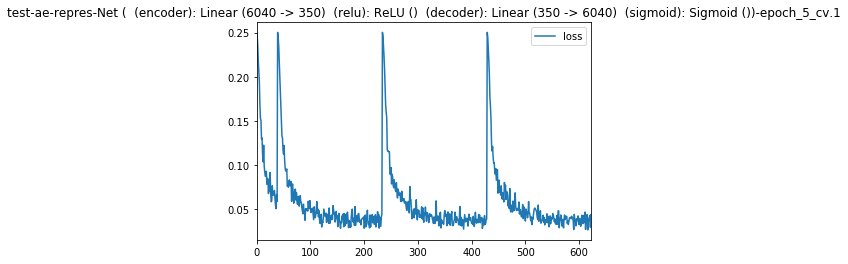

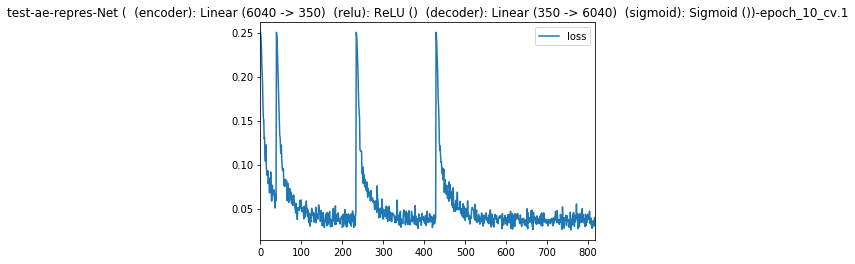

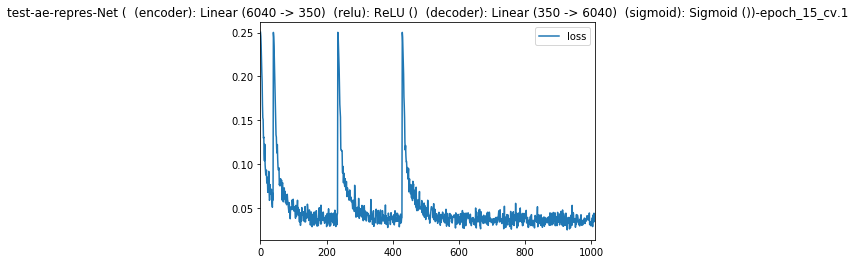

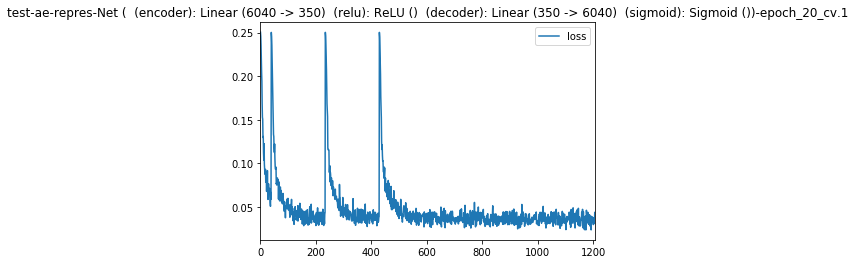

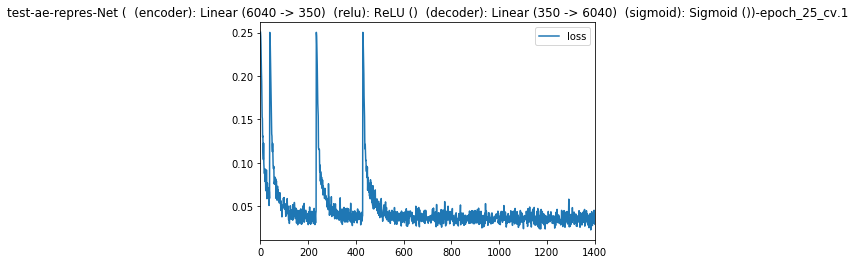

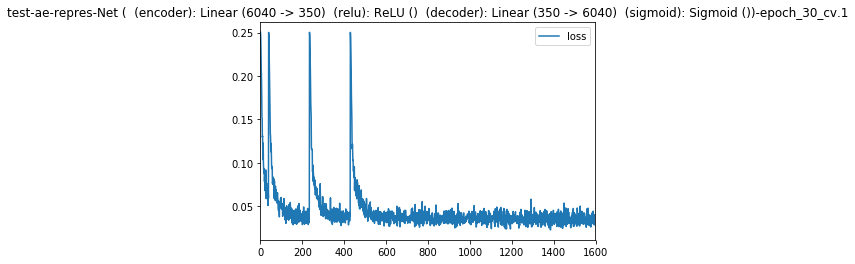

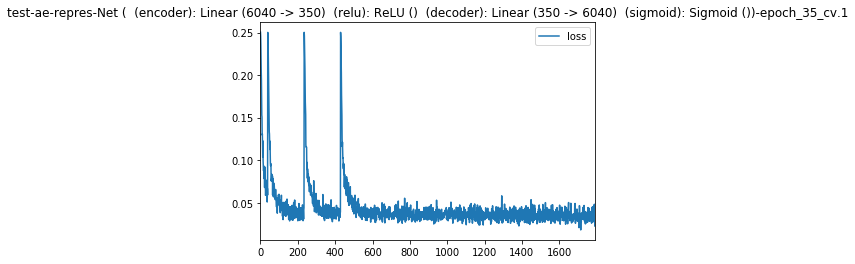

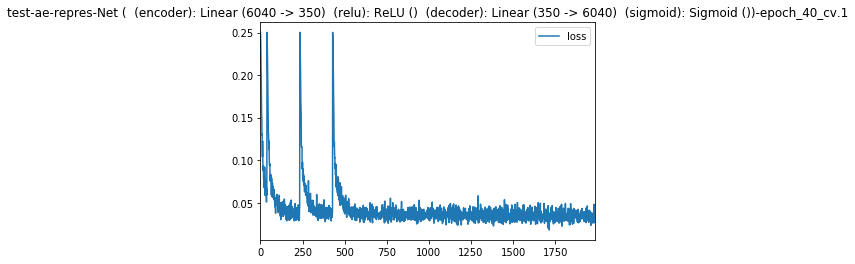

In [20]:
representations = dict()
pred_perf = dict()
cf_perf = dict()


net = Net(input_size, hidden_size, output_size)

certeria = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
print(net.train())
for epoch in range(num_epochs):
    for i_batch, sample_batched in enumerate(data3.train_loader):
#         print(i_batch,sample_batched)
        sample = Variable(sample_batched['sample'])
#         print(sample)
#         sample = Variable()
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(sample)
        loss = certeria(outputs, sample)
#         print(i_batch, loss.data[0])
        loss.backward()
        optimizer.step()
        
        print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   % (epoch + 1, num_epochs, i_batch + 1, 
                      len(data3.train_loader) ,loss.data[0]))
        loss_history.append(loss.data[0])
    iters = epoch +1
    if (iters) % 5 == 0:
#         model = copy.deepcopy(net)
        name = 'test-ae-repres-%s-epoch_%s_cv.%s'%(str(net).replace('\n',''), epoch+1, cv)
        torch.save(net.state_dict(), name)
        representations[iters] = dict()
        print('recommendataion on prediction... Epoch %s'%(iters))
        loss_df= pd.DataFrame(loss_history,columns=['loss'])
        loss_df.plot(title=name)
        predicted = np.zeros_like(data3.train_dataset.train)
        for key in net.representations.keys():
            representations[iters][key] = np.zeros((data3.train_dataset.train.shape[1]
                                                           ,net.representations[key].shape[1]))
#             print(key,(data3.train_dataset.train.shape[1]
#                                                            ,net.representations[key].shape[1]))
#         print('-'*60)
        for item_id in xrange(data3.train_dataset.train.shape[1]):
            sample = Variable(torch.from_numpy(data3.train_dataset.known[:,item_id]))
            output = net(sample)
            for key in net.representations.keys():
                r = representations[iters][key]
#                 print(key, net.representations[key].shape)
                r[item_id, :] = net.representations[key]

            predicted[ :,item_id] = output.data.numpy()
        rec_p = rec_pred(predicted)
        pred_perf[iters] = (rec_p.precision_, rec_p.recall_)
#         pred_perf[iters] = pred_recommend(train=data.train_dataset.train , test=data.test_dataset.test, predicted= predicted)
#         rec on hiddens
        cf_perf[iters] = dict()
        for key in net.representations.keys():
            cf_perf[iters][key]=dict()
            hidden_layer = representations[iters][key]
            cf = rec3.IBCF(sim='cosine')
            cf.fit(train_ratings = data3.train_dataset.train, profile=hidden_layer)
#             cf.compute_score(input_ratings = data3.train_dataset.known, topN=topN, targets=data3.test_dataset.targets)
#             cf.produce_reclist(targets=data3.test_dataset.targets)
#             cf.evaluate(test= data3.test_dataset.test, rec_len=5)
            for knn in [5,50,100,500,1000]:
                print('recommendataion on cf_hidden... Epoch %s, layper %s,topN %s'%(iters, key, knn))
                cf.compute_score(input_ratings = data3.train_dataset.known, topN=knn, targets=data3.test_dataset.targets)
                cf.produce_reclist(targets=data3.test_dataset.targets)
                tmp_perf = cf.evaluate(test= data3.test_dataset.test, rec_len=5)

                cf_perf[iters][key][knn] = tmp_perf


In [21]:
pred_perf

{5: (0.00066225165562913907, 3.7973145391579076e-06),
 10: (0.00099337748344370861, 5.6959718087368615e-06),
 15: (0.00066225165562913907, 3.7973145391579076e-06),
 20: (0.00099337748344370883, 1.3711261479713883e-05),
 25: (0.00066225165562913907, 3.7973145391579076e-06),
 30: (0.00033112582781456954, 1.2355441336364535e-05),
 35: (0.00066225165562913907, 3.7973145391579076e-06),
 40: (0.00099337748344370883, 2.3987913796143855e-05)}

In [22]:
cf_perf

{5: {'decode': {5: (0.39900662251655628, 0.040400165731181457),
   50: (0.43046357615894038, 0.043061073535436575),
   100: (0.41291390728476823, 0.037627646134842221),
   500: (0.3470198675496689, 0.030331975627618763),
   1000: (0.25960264900662255, 0.022626118116189552)},
  'decode_sigmoid': {5: (0.35927152317880795, 0.035633937113511642),
   50: (0.38543046357615895, 0.036161595242285689),
   100: (0.37516556291390735, 0.032999305174121418),
   500: (0.30728476821192058, 0.023879589577905647),
   1000: (0.27450331125827815, 0.021512861395148873)},
  'hidden': {5: (0.40927152317880794, 0.045010410129431175),
   50: (0.45099337748344365, 0.044916543929188403),
   100: (0.43476821192052983, 0.042227240198010732),
   500: (0.34337748344370861, 0.028961129596425186),
   1000: (0.27119205298013249, 0.023911545042859684)},
  'hidden_relu': {5: (0.4099337748344371, 0.043976054497309687),
   50: (0.44172185430463579, 0.043378123501791453),
   100: (0.43807947019867555, 0.043257727072019088)

In [25]:
cf_perf_list = []
for iteration in cf_perf.keys():
    d1 = cf_perf[iteration]
    for hidden in d1.keys():
        d2 = d1[hidden]
        for knn in d2.keys():
            v3 = d2[knn]
            cf_perf_list.append((iteration, hidden, knn,v3[0], v3[1]))

In [31]:
cf_perf_df = pd.DataFrame(cf_perf_list, columns=['iteration','hidden','knn','precision','recall'])

In [34]:
cf_perf_df = cf_perf_df.sort_values(by=['iteration','hidden','knn'])

In [36]:
cf_perf_df[cf_perf_df.hidden == 'hidden_relu'].groupby('iteration').max()

,hidden,knn,precision,recall
iteration,,,,
5,hidden_relu,1000,0.441722,0.043976
10,hidden_relu,1000,0.422185,0.043285
15,hidden_relu,1000,0.367550,0.039214
20,hidden_relu,1000,0.324503,0.036143
25,hidden_relu,1000,0.311258,0.035734
30,hidden_relu,1000,0.321192,0.036395
35,hidden_relu,1000,0.328146,0.037362
40,hidden_relu,1000,0.319868,0.035779


In [37]:
representations

{5: {'decode': array([[-313.60137939, -290.26098633, -251.15730286, ..., -242.86627197,
          -262.12338257, -286.65292358],
         [-128.71069336, -119.61745453, -105.00337982, ..., -101.04529572,
          -109.05025482, -118.36907196],
         [ -90.90750885,  -84.5661087 ,  -74.66553497, ...,  -71.89424896,
           -77.55014038,  -84.41278839],
         ..., 
         [ -18.38419533,  -17.40944481,  -16.32785797, ...,  -16.18459129,
           -16.96674156,  -18.1637249 ],
         [ -18.01612282,  -17.27796936,  -16.53743935, ...,  -16.51190567,
           -17.09047127,  -18.2732029 ],
         [ -75.86652374,  -69.59931946,  -61.58356857, ...,  -61.47154236,
           -65.26461029,  -71.00270844]]),
  'decode_sigmoid': array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.000

run hidden with larger neighborhood

In [45]:
for epoch in range(num_epochs):
    
    iters = epoch +1
    if (iters) % 5 == 0:
#         model = copy.deepcopy(net)
#         cf_perf[iters] = dict()
        for key in net.representations.keys():
#             cf_perf[iters][key]=dict()
            hidden_layer = representations[iters][key]
            cf = rec3.IBCF(sim='cosine')
            cf.fit(train_ratings = data3.train_dataset.train, profile=hidden_layer)
#             cf.compute_score(input_ratings = data3.train_dataset.known, topN=topN, targets=data3.test_dataset.targets)
#             cf.produce_reclist(targets=data3.test_dataset.targets)
#             cf.evaluate(test= data3.test_dataset.test, rec_len=5)
            for knn in [1500,2000,3000]:
                print('recommendataion on cf_hidden... Epoch %s, layper %s,topN %s'%(iters, key, knn))
                cf.compute_score(input_ratings = data3.train_dataset.known, topN=knn, targets=data3.test_dataset.targets)
                cf.produce_reclist(targets=data3.test_dataset.targets)
                tmp_perf = cf.evaluate(test= data3.test_dataset.test, rec_len=5)

                cf_perf[iters][key][knn] = tmp_perf


recommendataion on cf_hidden... Epoch 5, layper decode,topN 1500
recommendataion on cf_hidden... Epoch 5, layper decode,topN 2000
recommendataion on cf_hidden... Epoch 5, layper decode,topN 3000
recommendataion on cf_hidden... Epoch 5, layper decode_sigmoid,topN 1500
recommendataion on cf_hidden... Epoch 5, layper decode_sigmoid,topN 2000
recommendataion on cf_hidden... Epoch 5, layper decode_sigmoid,topN 3000
recommendataion on cf_hidden... Epoch 5, layper hidden,topN 1500
recommendataion on cf_hidden... Epoch 5, layper hidden,topN 2000
recommendataion on cf_hidden... Epoch 5, layper hidden,topN 3000
recommendataion on cf_hidden... Epoch 5, layper hidden_relu,topN 1500
recommendataion on cf_hidden... Epoch 5, layper hidden_relu,topN 2000
recommendataion on cf_hidden... Epoch 5, layper hidden_relu,topN 3000
recommendataion on cf_hidden... Epoch 10, layper decode,topN 1500
recommendataion on cf_hidden... Epoch 10, layper decode,topN 2000
recommendataion on cf_hidden... Epoch 10, layper 

KeyboardInterrupt: 

In [40]:
import copy

In [46]:
cf_perf_df[cf_perf_df.groupby('iteration')['precision'].transform(max) == cf_perf_df['precision']]

,iteration,hidden,knn,precision,recall
32,5,hidden,50,0.450993,0.044917
72,10,hidden,50,0.429801,0.044539
82,15,decode,50,0.409272,0.042521
102,20,decode,50,0.383444,0.040033
122,25,decode,50,0.370199,0.038453
142,30,decode,50,0.369205,0.038250
2,35,decode,50,0.377483,0.040138
42,40,decode,50,0.372517,0.038167


In [59]:
cf_perf_df

,iteration,hidden,knn,precision,recall
24,5,decode,5,0.399007,0.040400
22,5,decode,50,0.430464,0.043061
23,5,decode,100,0.412914,0.037628
21,5,decode,500,0.347020,0.030332
20,5,decode,1000,0.259603,0.022626
29,5,decode_sigmoid,5,0.359272,0.035634
27,5,decode_sigmoid,50,0.385430,0.036162
28,5,decode_sigmoid,100,0.375166,0.032999
26,5,decode_sigmoid,500,0.307285,0.023880
25,5,decode_sigmoid,1000,0.274503,0.021513


In [47]:
pred_perf

{5: (0.00066225165562913907, 3.7973145391579076e-06),
 10: (0.00099337748344370861, 5.6959718087368615e-06),
 15: (0.00066225165562913907, 3.7973145391579076e-06),
 20: (0.00099337748344370883, 1.3711261479713883e-05),
 25: (0.00066225165562913907, 3.7973145391579076e-06),
 30: (0.00033112582781456954, 1.2355441336364535e-05),
 35: (0.00066225165562913907, 3.7973145391579076e-06),
 40: (0.00099337748344370883, 2.3987913796143855e-05)}

In [41]:
cf_perf2 = copy.deepcopy(cf_perf)

In [38]:
import json

In [44]:
f = open('./ae_iter/cf_perf.json','w')
json.dump(cf_perf, f)

In [49]:
loss_history

[0.25039273500442505,
 0.24580471217632294,
 0.23534245789051056,
 0.21763432025909424,
 0.20447084307670593,
 0.19401994347572327,
 0.1680847555398941,
 0.15286104381084442,
 0.15074267983436584,
 0.1296674907207489,
 0.13083025813102722,
 0.11209475994110107,
 0.10374221205711365,
 0.12261921912431717,
 0.09926597774028778,
 0.09246417880058289,
 0.08756151050329208,
 0.08769895881414413,
 0.09314846247434616,
 0.07842930406332016,
 0.08515723794698715,
 0.08404219150543213,
 0.06784656643867493,
 0.08287616074085236,
 0.07064448297023773,
 0.09173549711704254,
 0.07071295380592346,
 0.058666378259658813,
 0.05960944667458534,
 0.07665758579969406,
 0.06645485758781433,
 0.06591451913118362,
 0.06612559407949448,
 0.07134775072336197,
 0.06283959746360779,
 0.054899848997592926,
 0.05079780891537666,
 0.06680402904748917,
 0.05898815393447876,
 0.25019803643226624,
 0.2451431304216385,
 0.23483242094516754,
 0.21797963976860046,
 0.19896648824214935,
 0.18331517279148102,
 0.17033600

In [50]:
loss_history2 = copy.deepcopy(loss_history)

In [51]:
loss_np = np.array(loss_history)

In [52]:
loss_np = (loss_np > 0.2).astype(int)

In [53]:
loss_np.nonzero()

(array([  0,   1,   2,   3,   4,  39,  40,  41,  42, 234, 235, 236, 237,
        238, 429, 430, 431, 432, 433]),)

In [56]:
429-234

195

In [57]:
195/39.0

5.0

In [58]:
(234-39)/39.0

5.0

In [63]:
predicted[0,:].nonzero()

(array([   3,    4,    7, ..., 3880, 3881, 3882]),)

In [73]:
predicted[ predicted<0.1].shape

(23248698,)

In [74]:
predicted[ predicted>0.9].shape

(103366,)

In [87]:
((6040*6040) -predicted[ predicted<0.1].shape[0]+predicted[ predicted>0.9].shape[0] )*1.0/(6040*6040)

0.3655614885312048

In [85]:
((6040*6040) -predicted[ predicted<0.2].shape[0]+predicted[ predicted>0.8].shape[0] )*1.0/(6040*6040)

0.36509116924696283